In [1]:
%load_ext autoreload

In [2]:
import numpy as np
from functools import partial
from iris_plant_visualizer import IrisPlantVisualizer
import ipywidgets as widgets
from IPython.display import display
from scipy.linalg import block_diag
from pydrake.all import InverseKinematics

In [3]:
#pydrake imports
from pydrake.common import FindResourceOrThrow
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.framework import DiagramBuilder
from pydrake.geometry import Role, GeometrySet, CollisionFilterDeclaration
from pydrake.all import RigidTransform, RollPitchYaw, RevoluteJoint
from pydrake.all import RotationMatrix, Rgba, VPolytope, BodyIndex,JacobianWrtVariable
import time
import pydrake.multibody.rational as rational_forward_kinematics
from pydrake.all import RationalForwardKinematics
from pydrake.geometry.optimization import IrisOptions, IrisInRationalConfigurationSpace, HPolyhedron, Hyperellipsoid
from pydrake.solvers import MosekSolver, CommonSolverOption, SolverOptions
from visprm import VPRMSeeding

In [4]:
from pydrake.geometry.optimization_dev import (CspaceFreePolytope,
                                               SeparatingPlane,
                                               SeparatingPlaneOrder)
from pydrake.common import (
    FindResourceOrThrow, )
from pydrake.systems.framework import (Context, Diagram, DiagramBuilder)
from pydrake.multibody.plant import (AddMultibodyPlantSceneGraph,
                                     CoulombFriction, MultibodyPlant)
from pydrake.multibody.rational import RationalForwardKinematics
from pydrake.multibody.tree import (ModelInstanceIndex)
from pydrake.multibody.parsing import Parser
from pydrake.multibody.inverse_kinematics import InverseKinematics
from pydrake.math import (RigidTransform, RollPitchYaw)
from pydrake.solvers.mosek import MosekSolver
from pydrake.solvers.osqp import OsqpSolver
from pydrake.solvers import mathematicalprogram as mp

In [5]:
from pydrake.geometry.optimization_dev import (CspaceFreePolytope, 
                                               SeparatingPlaneOrder)

In [6]:
from ur3e_demo import UrDiagram
import visualization_utils as viz_utils

# Build and set up the visualization the plant



In [7]:
ur = UrDiagram(num_ur = 1, weld_wrist = True, add_shelf = True,
                 add_gripper = True)
diagram_context = ur.diagram.CreateDefaultContext()
diagram = ur.diagram.ForcedPublish(diagram_context)

plant_context = ur.plant.GetMyMutableContextFromRoot(
        diagram_context)
        
# construct the RationalForwardKinematics of this plant. This object handles the
# computations for the forward kinematics in the tangent-configuration space
Ratfk = RationalForwardKinematics(ur.plant)

# the point about which we will take the stereographic projections
q_star = np.zeros(ur.plant.num_positions())

# The object we will use to perform our certification.
cspace_free_polytope = CspaceFreePolytope(ur.plant, ur.scene_graph,
                                          SeparatingPlaneOrder.kAffine, q_star)


INFO:drake:Meshcat listening for connections at http://localhost:7000


http://localhost:7000


## Set up the sliders so we can move the plant around manually

You can use the sliders below to move the two degrees of freedom of the plant around. A green dot will appear in the TC-space visualization describing the current TC-space configuration.

In [8]:
sliders = []
for i in range(ur.plant.num_positions()):
    q_low = ur.plant.GetPositionLowerLimits()[i]
    q_high = ur.plant.GetPositionUpperLimits()[i]
    sliders.append(widgets.FloatSlider(min=q_low, max=q_high, value=0, description=f"q{i}"))

q = np.zeros(ur.plant.num_positions())
def handle_slider_change(change, idx):
    q[idx] = change['new']
    ur.plant.SetPositions(plant_context, q)
    ur.diagram.ForcedPublish(diagram_context)
    
idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

for slider in sliders:
    display(slider)


FloatSlider(value=0.0, description='q0', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q1', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q2', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q3', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q4', max=2.827433388230814, min=-2.827433388230814)

In [9]:
pos = np.zeros(3)
xyz_sliders = []
for i in ["x","y","z"]:
    xyz_sliders.append(widgets.FloatSlider(min=0, max=10, value=0, description=i))
xyz = np.zeros(3)
def handle_slider_change_xyz(change, idx):
    xyz[idx] = change['new']
    viz_utils.plot_point(xyz, ur.meshcat, "/xyz", radius = 0.05)

idx = 0
for slider in xyz_sliders:
    slider.observe(partial(handle_slider_change_xyz, idx = idx), names='value')
    idx+=1

for slider in xyz_sliders:
    display(slider)

FloatSlider(value=0.0, description='x', max=10.0)

FloatSlider(value=0.0, description='y', max=10.0)

FloatSlider(value=0.0, description='z', max=10.0)

In [10]:
points_in_shelves = np.array([
    [0.55, 0, 0.10],
    [0.55, 0, 0.40],
    [0.55, 0, 0.65],
])

In [11]:
# def find_ur_posture_from_xyz(plant,
#                           plant_context,
#                           q_init = np.array([-0.4, 0.7, -0., 0.7, 0.5])):
#     ik = InverseKinematics(plant, plant_context)
#     ee_frame = plant.GetFrameByName("ur_ee_link")
#     gripper_frame = plant.GetBodyByName("body", ur.gripper_instances[0]).body_frame()
#     shelf_frame = plant.GetFrameByName("shelves_body")
#     ik.AddPositionConstraint(gripper_frame, np.zeros((3, )), shelf_frame,
#                              np.array([-0.15, -0., -0.2]),
#                              np.array([0.05, 0., 0.2]))
#     ik.AddPositionConstraint(gripper_frame, np.array([0, 0.028, 0]),
#                              shelf_frame, np.array([-0.05, -0.02, -0.15]),
#                              np.array([0.05, 0.02, 0.08]))
#     ik.AddAngleBetweenVectorsConstraint(gripper_frame, np.array([1, 0, 0.]),
#                                         plant.world_frame(),
#                                         np.array([0, 0, 1]), 0.3 * np.pi,
#                                         0.7 * np.pi)
#     #right_finger = plant.GetBodyByName("right_finger", gripper_instance)
#     #ik.AddPositionConstraint(right_finger.body_frame(), np.array([0., 0., 0.]),
#     #                         shelf_frame, np.array([-0.15, 0.04, -0.15]),
#     #                         np.array([0.15, 0.1, 0.2]))
#     #left_finger = plant.GetBodyByName("left_finger", gripper_instance)
#     #ik.AddPositionConstraint(left_finger.body_frame(), np.array([0., 0., 0.]),
#     #                         shelf_frame, np.array([-0.15, -0.1, -0.15]),
#     #                         np.array([0.15, -0.01, 0.2]))
#     ik.AddMinimumDistanceConstraint(0.015)

#     ik.get_mutable_prog().SetInitialGuess(ik.q(), q_init)
#     result = mp.Solve(ik.prog(), q_init, None)
#     if not result.is_success():
#         raise Warning("Cannot find the posture")
#     print(result.GetSolution(ik.q()))
#     return result.GetSolution(ik.q())

In [12]:
def find_ur_posture_from_xyz(plant,
                          plant_context,
                          target_z = 0,
                          q_init = np.array([-0.4, 0.7, -0., 0.7, 0.5])):
    ik = InverseKinematics(plant, plant_context)
    ee_frame = plant.GetFrameByName("ur_ee_link")
    gripper_frame = plant.GetBodyByName("body", ur.gripper_instances[0]).body_frame()
    shelf_frame = plant.GetFrameByName("top_and_bottom")
    ik.AddPositionConstraint(gripper_frame, np.zeros((3, )), shelf_frame,
                             np.array([-0.15, -0., target_z-0.2]),
                             np.array([0.05, 0.,target_z+ 0.2]))
    ik.AddPositionConstraint(gripper_frame, np.array([0, 0.028, 0]),
                             shelf_frame, np.array([-0.05, -0.02, target_z-0.15]),
                             np.array([0.05, 0.02, target_z+0.08]))
    ik.AddAngleBetweenVectorsConstraint(gripper_frame, np.array([1, 0, 0.]),
                                        plant.world_frame(),
                                        np.array([0, 0, 1]), 0.3 * np.pi,
                                        0.7 * np.pi)
    ik.AddMinimumDistanceConstraint(0.015)

    ik.get_mutable_prog().SetInitialGuess(ik.q(), q_init)
    result = mp.Solve(ik.prog(), q_init, None)
    if not result.is_success():
        raise Warning("Cannot find the posture")
    print(result.GetSolution(ik.q()))
    return result.GetSolution(ik.q())

In [13]:
q_middle_initial = np.array([-1.03, -1.43, -0.03, 0.67, 0.57])
q_middle_shelf = find_ur_posture_from_xyz(ur.plant, plant_context,
                                          q_init=q_middle_initial)
ur.plant.SetPositions(plant_context, q_middle_shelf)
ur.diagram.ForcedPublish(diagram_context)

[-0.40617389 -0.27540927 -0.78904839  0.93653257  1.05187696]


In [14]:
idx = 0
q = np.zeros(ur.plant.num_positions())
def handle_slider_change(change, idx):
    q[idx] = change['new']
    ur.plant.SetPositions(plant_context, q)
    ur.diagram.ForcedPublish(diagram_context)

idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1
    
for slider in sliders:
    display(slider)

FloatSlider(value=0.0, description='q0', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q1', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q2', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q3', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q4', max=2.827433388230814, min=-2.827433388230814)

In [15]:
# q_top_init = np.array([-0.33, -0.93, -0.53, -1.63, -1.13])
q_top_shelf = np.array([-0.63, -1.03, 0.17, -2.33, -0.73])
ur.plant.SetPositions(plant_context, q_top_shelf)
ur.diagram.ForcedPublish(diagram_context)

In [16]:
# q_bottom_init = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
# q_bottom_shelf = find_ur_posture_from_xyz(ur.plant, plant_context, 
#                                           q_init = q_bottom_init,
#                                           target_z = -1)
q_bottom_shelf = np.array([-0.13, -0.43, 0.87, -0.43, 1.57])
ur.plant.SetPositions(plant_context, q_bottom_shelf)
ur.diagram.ForcedPublish(diagram_context)

In [17]:
seedpoints = [q_top_shelf, 
              q_middle_shelf, 
              q_bottom_shelf]

In [18]:
def pull_back_point(pt):
    ur.plant.SetPositions(plant_context, pt)
    shunk = ur.plant.GetBodyByName("body", ur.gripper_instances[0])
    shunk_frame = shunk.body_frame()
    world_frame = ur.plant.world_frame() 
    J = ur.plant.CalcJacobianSpatialVelocity(plant_context, 
                                          JacobianWrtVariable.kQDot,
                                            shunk_frame,
                                            [0,0,0],
                                            world_frame,
                                         world_frame)

#     print(J)
    #shunk = plant.get_body(pydrake.multibody.tree.BodyIndex(9))
    tf_tot = shunk.EvalPoseInWorld(plant_context)
    tf = tf_tot.translation()

    # tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
    v_pullback = -tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.05
    print(v_pullback)
    pos_pullback = tf + v_pullback
    pt_new = pt + np.linalg.pinv(J[3:,:])@v_pullback
    return pt_new

helpers = []
for p in seedpoints:
    ph = pull_back_point(p)
    helpers.append(ph)
helpers = np.array(helpers)
        
# for i, p in enumerate(seedpoints):
#     plot_endeff_pose(p, str(i))
    
seedpoints = np.concatenate((seedpoints, helpers), axis = 0)

[-0.04886167 -0.01048494 -0.00161344]
[-0.04935663 -0.00576551 -0.00553909]
[-0.04958076  0.0064419   0.00049999]


In [19]:

def plot_points(points, 
                size = 0.02, 
                color = Rgba(0.06, 0.0, 0, 1), 
                start_idx = 0, 
                prefix = 'point'):
       
        
        for i in range(points.shape[0]):
            pt = points[i]
            ur.plant.SetPositions(plant_context, pt)
            tf_tot= ur.plant.EvalBodyPoseInWorld(plant_context, ur.plant.get_body(BodyIndex(7)))
            tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.25
            viz_utils.plot_point(tf, ur.meshcat, f"/seed_point{i}", radius = 0.05)

In [20]:
plot_points(np.array(seedpoints))

In [21]:
#generate function hanldes


ik = InverseKinematics(ur.plant, plant_context)
collision_constraint = ik.AddMinimumDistanceConstraint(0.001, 0.001)

def eval_cons(q, c, tol):
    return 1-1*float(c.evaluator().CheckSatisfied(q, tol))
    
col_func_handle = partial(eval_cons, c=collision_constraint, tol=0.01)


#sample based LOS checker
def vis(t1, t2, num_checks):
    t1flat = t1.reshape(-1)
    t2flat = t2.reshape(-1)
    if np.linalg.norm(t1-t2) < 1e-6:
        return [(1-col_func_handle(Ratfk.ComputeQValue(t1flat, np.zeros(7))))>0,
                None]
    tvec = np.linspace(0,1, num_checks)
    for t in tvec:
        tinterp = t1flat*t + (1-t)*t2flat
        if col_func_handle(Ratfk.ComputeQValue(tinterp, np.zeros(7))):
            return [False, None]
    else:
        return [True, None]
is_LOS = partial(vis, num_checks = 40)


In [22]:
col_func_handle(np.ones(5))
ur.plant.SetPositions(plant_context, np.ones(5))
ur.diagram.ForcedPublish(diagram_context)

In [23]:
iris_regions = []
iris_ellipses = []

iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.configuration_space_margin = 1e-3
iris_options.relative_termination_threshold = 0.001

def IrisInRationalConfigurationSpaceV2(q,
                                       plant, 
                                         plant_context,
                                         q_star, iris_options,
                                    ):
    plant.SetPositions(plant_context, q)
    return IrisInRationalConfigurationSpace(plant, 
                                         plant_context,
                                         q_star, iris_options)


def SNOPT_IRIS(q_seed,  regions, plant, context, snoptiris_options, qstar):
    #print('snopt iris call')
    snoptiris_options.configuration_obstacles = []
    if regions is not None:
        obstacles = []
        for r in regions:
            offset = 0.25*np.min(1/np.linalg.eig(r.MaximumVolumeInscribedEllipsoid().A())[0])
            rnew = HPolyhedron(r.A(), r.b()-offset)
            obstacles.append(rnew)
        snoptiris_options.configuration_obstacles = obstacles
    plant.SetPositions(plant.GetMyMutableContextFromRoot(context), q_seed.reshape(-1,1))
    t_seed = Ratfk.ComputeSValue(q_seed, np.zeros(7))
    r = IrisInRationalConfigurationSpace(plant, plant.GetMyContextFromRoot(context), qstar, snoptiris_options)
    return r


SNOPT_IRIS_Handle_old = partial(IrisInRationalConfigurationSpaceV2,
                            plant = ur.plant,
                            plant_context = plant_context,
                            q_star = q_star,
                            iris_options = iris_options)

SNOPT_IRIS_Handle1 = partial(SNOPT_IRIS,
                            plant = ur.plant,
                            context = diagram_context,
                            qstar = q_star,
                            snoptiris_options = iris_options)

# IrisInRationalConfigurationSpace(ur.plant, 
#                                  plant_context,
#                                  q_star, iris_options)

In [24]:

vs = VPRMSeeding(seedpoints,
                 alpha = 0.05,
                 eps = 0.05,
                 limits = [ur.plant.GetPositionLowerLimits(), 
                           ur.plant.GetPositionUpperLimits()],
                 collision_handle = col_func_handle,
                 is_in_line_of_sight = is_LOS, 
                 iris_handle=partial(SNOPT_IRIS_Handle1, regions = None),
                 iris_handle_with_obstacles = SNOPT_IRIS_Handle1,
                 point_to_region_conversion = partial(Ratfk.ComputeSValue, q_star_val = q_star),
                 #ranking_samples_handle = sample_ranking_connected_components_weight
                 )
vs.set_guard_regions()

[00:49:21] [VPRMSeeding] Expecting points of interest in q
[00:49:21] [VPRMSeeding] GuardInsertion attempts M: 58
[00:49:21] [VPRMSeeding] 0.95 probability that unseen region is less than 5.0 "%" of Cfree 


In [25]:
vs.guard_phase()
vs.refine_guards_greedy()

[00:49:51] [VPRMSeeding] New guard placed N =  6 it =  3
[00:49:55] [VPRMSeeding] Sample set size 3
[00:49:55] [VPRMSeeding] New guard placed N =  7 it =  9
[00:50:01] [VPRMSeeding] Sample set size 11
[00:50:01] [VPRMSeeding] New guard placed N =  8 it =  5
[00:50:32] [VPRMSeeding] Sample set size 15
[00:50:32] [VPRMSeeding] New guard placed N =  9 it =  7
[00:50:39] [VPRMSeeding] Sample set size 21
[00:50:40] [VPRMSeeding] New guard placed N =  10 it =  31
[00:50:48] [VPRMSeeding] Sample set size 51
[00:50:49] [VPRMSeeding] New guard placed N =  11 it =  12
[00:51:03] [VPRMSeeding] Sample set size 62
[00:51:03] [VPRMSeeding] New guard placed N =  12 it =  3
[00:51:44] [VPRMSeeding] Sample set size 64
[00:51:45] [VPRMSeeding] New guard placed N =  13 it =  54
[00:51:49] [VPRMSeeding] Sample set size 117
[00:51:49] [VPRMSeeding] New guard placed N =  14 it =  15
[00:51:56] [VPRMSeeding] Sample set size 131
1
1
1
2
1
1
1
10
11
2
3
1
1
1
1
[00:52:00] [VPRMSeeding] Guard found to split int

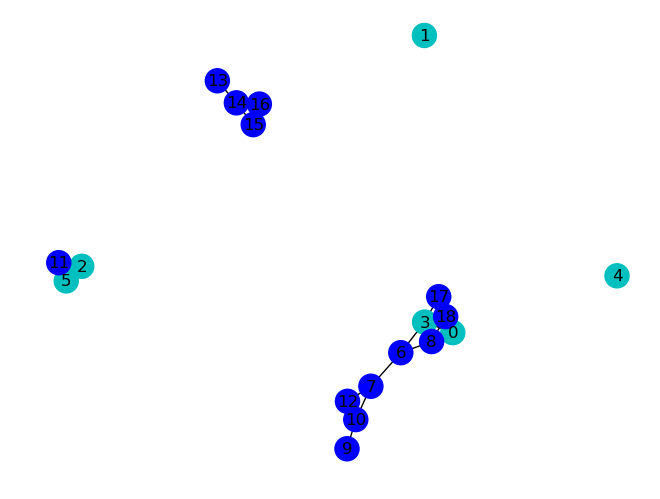

In [26]:
import matplotlib.pyplot as plt
vs.draw_connectivity_graph()
plt.show()

In [27]:
vs.connectivity_phase()

[00:54:16] [VPRMSeeding] Num connected Components Vis: 4
[00:54:18] [VPRMSeeding] Failed, deleting point
[00:54:18] [VPRMSeeding] Num connected Components Vis: 3
[00:54:53] [VPRMSeeding] New region added [ 0.54298704 -2.03085288  1.99110634  0.71747592  2.59407395]
[00:54:53] [VPRMSeeding] Sample set size 138 num keys to del  3
[00:54:53] [VPRMSeeding] Num connected Components Vis: 3
[00:55:40] [VPRMSeeding] New region added [ 1.94056712 -2.61970891 -2.69128191  1.69956345  1.27995813]
[00:55:40] [VPRMSeeding] Sample set size 137 num keys to del  1
[00:55:41] [VPRMSeeding] Num connected Components Vis: 3
[00:56:16] [VPRMSeeding] New region added [-1.65501328 -2.17057456  2.08012979 -0.94602893  0.16915638]
[00:56:16] [VPRMSeeding] Sample set size 131 num keys to del  6
[00:56:16] [VPRMSeeding] Num connected Components Vis: 3
[00:56:49] [VPRMSeeding] New region added [-1.71817583 -0.08291432 -1.6017848   1.69450699 -1.76965399]
[00:56:49] [VPRMSeeding] Sample set size 127 num keys to de

True

In [28]:
# vs.sample_rank_handle(vs)

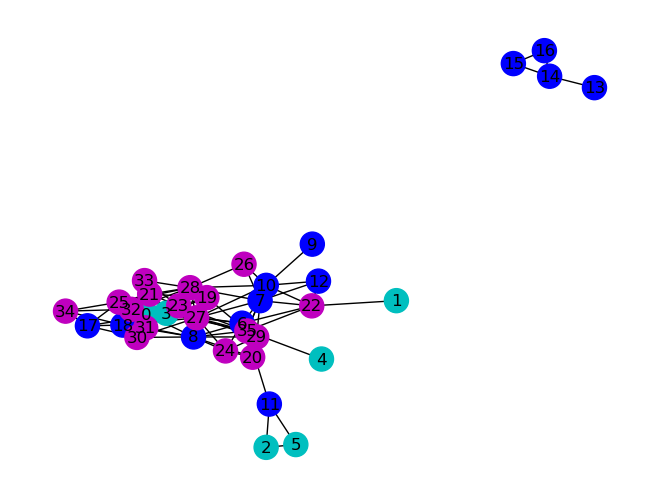

In [29]:
vs.draw_connectivity_graph()
plt.show()

In [30]:
regions = vs.regions
region = regions[0]

# Generate and Certify Regions

Around some nominal seed postures, we will grow certified regions by seeding our alternation algorithm using a small initial polytope.

In [31]:
# Some seedpoints
# seed_points_q = np.array([   
#                               q_top_shelf,
#                               q_middle_shelf,
#                               q_bottom_shelf
#                               ])

# seed_points = np.array([Ratfk.ComputeSValue(seed_points_q[idx], q_star)\
#                         for idx in range(seed_points_q.shape[0])])
# start = seed_points[0]
# end = seed_points[-1]

    

# visualizer.add_plane_indices_of_interest(118)

## First we set up some options for our different certification modes

In [32]:
# set up the certifier and the options for different search techniques
solver_options = SolverOptions()
# set this to 1 if you would like to see the solver output in terminal.
solver_options.SetOption(CommonSolverOption.kPrintToConsole, 0)

# The options for when we search for new planes and positivity certificates given the polytopes
find_separation_certificate_given_polytope_options = CspaceFreePolytope.FindSeparationCertificateGivenPolytopeOptions()
find_separation_certificate_given_polytope_options.num_threads = -1
find_separation_certificate_given_polytope_options.verbose = False
find_separation_certificate_given_polytope_options.solver_options = solver_options
find_separation_certificate_given_polytope_options.ignore_redundant_C = False

# The options for when we search for a new polytope given positivity certificates.
find_polytope_given_lagrangian_option = CspaceFreePolytope.FindPolytopeGivenLagrangianOptions()
find_polytope_given_lagrangian_option.solver_options = solver_options
find_polytope_given_lagrangian_option.ellipsoid_margin_cost = CspaceFreePolytope.EllipsoidMarginCost.kGeometricMean
find_polytope_given_lagrangian_option.search_s_bounds_lagrangians = True
find_polytope_given_lagrangian_option.ellipsoid_margin_epsilon = 1e-8


bilinear_alternation_options = CspaceFreePolytope.BilinearAlternationOptions()
bilinear_alternation_options.max_iter = 100
bilinear_alternation_options.convergence_tol = 1e-5
bilinear_alternation_options.find_polytope_options = find_polytope_given_lagrangian_option
bilinear_alternation_options.find_lagrangian_options = find_separation_certificate_given_polytope_options

binary_search_options = CspaceFreePolytope.BinarySearchOptions()
binary_search_options.find_lagrangian_options = find_separation_certificate_given_polytope_options
binary_search_options.scale_min = 1
binary_search_options.scale_max = 50
binary_search_options.max_iter = 10


In [33]:
progs = cspace_free_polytope.ConstructPlaneSearchProgramsForPairs(region.A(), region.b(), find_separation_certificate_given_polytope_options)

In [34]:
len(cspace_free_polytope.separating_planes())

112

In [35]:
cert_prog = progs[0].prog()
print(cert_prog.num_vars())
print(len(cert_prog.GetAllConstraints()))

24984
1896


## Seeding and Certifying with a Stronger Heuristic
We have also implemented another, strong heuristic for proposing good initial regions based on non-linear optimization. See Appendix TODO of our paper TODO for details

In [36]:
# iris_regions = []
# iris_ellipses = []
# seed_points = poi
# iris_options = IrisOptions()
# iris_options.require_sample_point_is_contained = True
# iris_options.configuration_space_margin = 1e-3
# iris_options.relative_termination_threshold = 0.001

# for i, s in enumerate(seed_points):
#     q = Ratfk.ComputeQValue(s, q_star)
#     ur.plant.SetPositions(plant_context, q)
#     r = IrisInRationalConfigurationSpace(ur.plant, 
#                                          plant_context,
#                                          q_star, iris_options)
#     iris_regions.append(r)
#     iris_ellipses.append(r.MaximumVolumeInscribedEllipsoid())
    


In [37]:
# iris_regions[0].b().shape[0]

In [38]:
binary_search_options_for_iris = CspaceFreePolytope.BinarySearchOptions()
binary_search_options_for_iris.scale_max = 1.0 # it is highly unlikely that the regions can grow
binary_search_options_for_iris.scale_min = 1e-3
# binary_search_options_for_iris.find_lagrangian_options = find_separation_certificate_given_polytope_options
binary_search_options_for_iris.max_iter = 5
binary_search_options_for_iris.find_lagrangian_options.verbose = False
# binary_search_region_certificates_for_iris = dict.fromkeys([tuple(s) for s in seed_points])
certified_regions = []
certificates = []
times_per_region = []

for i, initial_region in enumerate(regions):
    print(f"starting seedpoint {i+1}/{len(regions)}")
    time.sleep(0.2)    
    t_start = time.perf_counter()
    cert = cspace_free_polytope.BinarySearch(set(),
                                                    initial_region.A(),
                                                    initial_region.b(), 
                                                    initial_region.MaximumVolumeInscribedEllipsoid().center(), 
                                                    binary_search_options_for_iris)
    t_end = time.perf_counter()
    times_per_region.append(t_end - t_start)
    if cert is not None:
        certified_regions.append(cert.certified_polytope)
        certificates.append(cert)

starting seedpoint 1/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.75025 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.625375 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.6878124999999999 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.71903125 is infeasible


starting seedpoint 2/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.25075 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.125875 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.0634375 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.09465625 is feasible


starting seedpoint 3/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.75025 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.625375 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5629375 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5941562499999999 is feasible


starting seedpoint 4/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.75025 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.625375 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5629375 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.53171875 is feasible


starting seedpoint 5/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.75025 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.625375 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5629375 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5941562499999999 is feasible


starting seedpoint 6/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.75025 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.8751249999999999 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.8126875 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.84390625 is feasible


starting seedpoint 7/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.25075 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.375625 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.43806249999999997 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.46928125 is infeasible


starting seedpoint 8/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.75025 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.625375 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5629375 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5941562499999999 is feasible


starting seedpoint 9/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.25075 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.375625 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.31318749999999995 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.28196875 is infeasible


starting seedpoint 10/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.25075 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.125875 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.1883125 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.15709374999999998 is feasible


starting seedpoint 11/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.25075 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.375625 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.31318749999999995 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.28196875 is feasible


starting seedpoint 12/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.75025 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.625375 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.6878124999999999 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.65659375 is infeasible


starting seedpoint 13/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.75025 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.625375 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.6878124999999999 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.71903125 is infeasible


starting seedpoint 14/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.25075 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.375625 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.31318749999999995 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.34440624999999997 is feasible


starting seedpoint 15/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.25075 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.375625 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.31318749999999995 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.34440624999999997 is infeasible


starting seedpoint 16/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.25075 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.375625 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.43806249999999997 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.40684374999999995 is infeasible


starting seedpoint 17/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.25075 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.375625 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.31318749999999995 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.34440624999999997 is feasible


starting seedpoint 18/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.25075 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.375625 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.43806249999999997 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.46928125 is feasible


starting seedpoint 19/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.25075 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.375625 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.43806249999999997 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.40684374999999995 is infeasible


starting seedpoint 20/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.25075 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.375625 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.31318749999999995 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.34440624999999997 is infeasible


starting seedpoint 21/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.25075 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.375625 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.31318749999999995 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.28196875 is infeasible


starting seedpoint 22/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.25075 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.125875 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.1883125 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.21953124999999998 is feasible


starting seedpoint 23/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.75025 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.625375 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5629375 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5941562499999999 is infeasible


starting seedpoint 24/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.75025 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.625375 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5629375 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.53171875 is feasible


starting seedpoint 25/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.25075 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.125875 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.1883125 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.21953124999999998 is infeasible


starting seedpoint 26/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.25075 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.375625 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.43806249999999997 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.40684374999999995 is feasible


starting seedpoint 27/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.25075 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.375625 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.43806249999999997 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.40684374999999995 is infeasible


starting seedpoint 28/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.75025 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.625375 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5629375 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5941562499999999 is infeasible


starting seedpoint 29/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.25075 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.375625 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.43806249999999997 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.40684374999999995 is infeasible


starting seedpoint 30/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.75025 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.625375 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.6878124999999999 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.65659375 is feasible


starting seedpoint 31/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.25075 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.375625 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.31318749999999995 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.34440624999999997 is infeasible


starting seedpoint 32/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.75025 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.625375 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.6878124999999999 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.71903125 is feasible


starting seedpoint 33/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.25075 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.375625 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.31318749999999995 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.28196875 is infeasible


starting seedpoint 34/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.75025 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.625375 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.6878124999999999 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.71903125 is feasible


starting seedpoint 35/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.25075 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.375625 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.31318749999999995 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.34440624999999997 is infeasible


starting seedpoint 36/36


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5005 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.75025 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.625375 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.6878124999999999 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.65659375 is feasible


In [39]:
print(len(regions))
print(len(certified_regions))

36
36


In [40]:
for i, t in enumerate(times_per_region):
    print(f"Time to generate region {i} ={times_per_region[i]}")
print(f"Total time = {sum(times_per_region)}")

Time to generate region 0 =49.758683955005836
Time to generate region 1 =59.57303836097708
Time to generate region 2 =60.10006710502785
Time to generate region 3 =70.00588364800205
Time to generate region 4 =40.73014992696699
Time to generate region 5 =94.1546504709986
Time to generate region 6 =40.3055616110214
Time to generate region 7 =41.6998064200161
Time to generate region 8 =60.320954421011265
Time to generate region 9 =80.77090778300771
Time to generate region 10 =110.11396439798409
Time to generate region 11 =44.90144319599494
Time to generate region 12 =46.01291606295854
Time to generate region 13 =107.84709162899526
Time to generate region 14 =128.71690056298394
Time to generate region 15 =113.63210335501935
Time to generate region 16 =124.68484429398086
Time to generate region 17 =53.13218654500088
Time to generate region 18 =139.29582495300565
Time to generate region 19 =150.88921903504524
Time to generate region 20 =36.295805580040906
Time to generate region 21 =89.942452

In [41]:
v_region = VPolytope(region)
v_region.vertices().shape

(5, 104)

In [42]:
from pydrake.all import PiecewisePolynomial
def generate_walk_around_polytope(h_polytope, num_verts):
    v_polytope = VPolytope(h_polytope)
    verts_to_visit_index = np.random.randint(0, v_polytope.vertices().shape[1], num_verts)
    verts_to_visit = v_polytope.vertices()[:, verts_to_visit_index]
#     for i in range(len(verts_to_visit)-1):
#         cur_v = verts_to_visit[i]
#         next_v = verts_to_visit[i+1]
    t_knots = np.linspace(0, 1,  verts_to_visit.shape[1])
    lin_traj = PiecewisePolynomial.FirstOrderHold(t_knots, verts_to_visit)
    return lin_traj
lin_traj = generate_walk_around_polytope(region, 15)

In [43]:
def animate_traj_s(traj, steps, runtime, idx_list = None, sleep_time = 0.1):
    # loop
    idx = 0
    going_fwd = True
    time_points = np.linspace(0, traj.end_time(), steps)
    frame_count = 0
    for _ in range(runtime):
        # print(idx)
        t0 = time.time()
        s = traj.value(time_points[idx])
        q = Ratfk.ComputeQValue(s, q_star)
        ur.plant.SetPositions(plant_context, q)
        diagram_context.SetTime(frame_count * 0.01)
        ur.diagram.ForcedPublish(diagram_context)
        frame_count += 1
        if going_fwd:
            if idx + 1 < steps:
                idx += 1
            else:
                going_fwd = False
                idx -= 1
        else:
            if idx - 1 >= 0:
                idx -= 1
            else:
                going_fwd = True
                idx += 1
        t1 = time.time()
        pause = sleep_time - (t1 - t0)
        if pause > 0:
            time.sleep(pause)

In [47]:
from random import choice
r = choice(certified_regions)
lin_traj = generate_walk_around_polytope(r, 15)
substeps = 100
runtime = substeps
animate_traj_s(lin_traj, substeps, runtime)

In [ ]:
# from gcs.bezier import BezierGCS
# from gcs.linear import LinearGCS
# from pydrake.solvers.mosek import MosekSolver
# from pydrake.all import PiecewisePolynomial
# from visualization_utils import draw_traj

# start = seed_points[0]
# end = seed_points[-1]
# regions = [r for (r,_) in iris_regions]

# l_gcs = LinearGCS(regions)
# l_gcs.addSourceTarget(start, end)
# l_gcs.setSolver(MosekSolver())
# waypoints = l_gcs.SolvePath(True)[0]
# t_knots = np.linspace(0, 1,  waypoints.shape[1])
# lin_traj = PiecewisePolynomial.FirstOrderHold(t_knots, waypoints)

# draw_traj(visualizer.meshcat_cspace, lin_traj, 100)


In [ ]:
# substeps = 100
# runtime = 2*substeps
# # visualizer.animate_traj_s(lin_traj, substeps, runtime)
# visualizer.visualizer_task_space.StartRecording()
# visualizer.animate_traj_s(lin_traj, substeps, runtime)
# visualizer.visualizer_task_space.PublishRecording()


In [ ]:
# visualizer.save_meshcats("pinball_iiwas")

# Now it is time to play with the visualization! If you open the task space visualizer, we can highlight specific geometries and their separating planes in different regions.
## Notice that when regions overlap, we get multiple planes certifying non-collision

In [ ]:
# This plane certifies that the two tips of the flippers don't intersect
visualizer.add_plane_indices_of_interest(118)

# re-display the sliders for convenience
for slider in sliders:
    display(slider)

In [ ]:
# Uncomment this cell for an interface for choosing good planes of interest
# plane_indices = np.arange(0, len(cspace_free_polytope.separating_planes()))
# last_plane_index = 0
# cur_plane_index = 0
# plane_indices_to_geometries = {v: k for k,v in cspace_free_polytope.map_geometries_to_separating_planes().items()}

# while True:
#     visualizer.meshcat_task_space.Delete(f"/plane_{last_plane_index}")
#     geom1, geom2 = plane_indices_to_geometries[cur_plane_index]
#     color = Rgba(0,0,1,1)
    
#     prefix = f"/plane_{cur_plane_index}"
#     visualizer.highlight_geometry_id(geom1, color, prefix+f"/{geom1}")
#     visualizer.highlight_geometry_id(geom2, color, prefix+f"/{geom2}")
#     print(f"current plane index = {cur_plane_index}")
    
#     last_plane_index = cur_plane_index
#     valid_key_pressed = False
#     while not valid_key_pressed:
#         key_press = input("Enter d to increase plane_count, a to decrease, and e to exit...")
#         if key_press in ["a", "d", "e"]:
#             valid_key_pressed = True
#     if key_press == "a":
#         cur_plane_index = max(cur_plane_index - 1, min(plane_indices))
#     elif key_press == "d":
#         cur_plane_index = min(cur_plane_index + 1, max(plane_indices))
#     elif key_press == "e":
#         break
#     print()

In [ ]:
# Uncomment this cell for seeing all the planes associated to a particular geometry id
# interesting_geometry = 92
# plane_indices = np.arange(0, len(cspace_free_polytope.separating_planes()))
# plane_indices_to_geometries = {v: k for k,v in cspace_free_polytope.map_geometries_to_separating_planes().items()}

# associated_plane_indices = []
# for plane_index, (geom1, geom2) in plane_indices_to_geometries.items():
#     if interesting_geometry in (geom1.get_value(), geom2. get_value()):
#         associated_plane_indices.append(plane_index)

        
# last_associated_index_index = 0
# cur_associated_index_index = 0

# visualizer.clear_plane_indices_of_interest()
# while True:
#     last_plane_index = associated_plane_indices[last_associated_index_index]
#     cur_plane_index = associated_plane_indices[cur_associated_index_index]
    
#     print(f"current plane index = {cur_plane_index}")
    
#     visualizer.remove_plane_indices_of_interest(last_plane_index)
#     visualizer.add_plane_indices_of_interest(cur_plane_index)
    
#     cur_q = visualizer.plant.GetPositions(visualizer.plant_context)
#     visualizer.show_res_q(cur_q)
    
#     last_associated_index_index = cur_associated_index_index
#     valid_key_pressed = False
#     while not valid_key_pressed:
#         key_press = input("Enter d to increase plane_count, a to decrease, and e to exit...")
#         if key_press in ["a", "d", "e"]:
#             valid_key_pressed = True
#     if key_press == "a":
#         cur_associated_index_index = max(cur_associated_index_index - 1, min(associated_plane_indices))
#     elif key_press == "d":
#         cur_associated_index_index = min(cur_associated_index_index + 1, max(associated_plane_indices))
#     elif key_press == "e":
#         break
#     print()